# Visual Inspection of Motorcycle Connecting Rods

Students should develop a software system aimed at visual inspection of motorcycle connecting rods. The system should be able to analyse the dimensions of two different types of connecting rods to allow a vision-guided robot to pick and sort rods based on their type and dimensions. The two rod types are characterized by a different number of holes: Type A rods have one hole whilst Type B rods have two holes.

## Libraries and Data loading

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

import sys

sys.path.append(".")

data_folder = Path("ispezione-bielle-immagini")
task1_names = [
    "TESI00.BMP",
    "TESI01.BMP",
    "TESI12.BMP",
    "TESI21.BMP",
    "TESI31.BMP",
    "TESI33.BMP",
]

task2_names = [
    "TESI44.BMP",
    "TESI47.BMP",
    "TESI48.BMP",
    "TESI49.BMP",
    "TESI50.BMP",
    "TESI51.BMP",
    "TESI90.BMP",
    "TESI92.BMP",
    "TESI98.BMP",
]

paths_1 = []
paths_2 = []
for _path in data_folder.rglob("*.BMP"):
    if _path.name.upper() in task1_names:
        paths_1.append(_path)
    elif _path.name.upper() in task2_names:
        paths_2.append(_path)

# Load the images
images_1 = [cv2.imread(str(_path), cv2.IMREAD_GRAYSCALE) for _path in paths_1]
images_2 = [cv2.imread(str(_path), cv2.IMREAD_GRAYSCALE) for _path in paths_2]

## First task

**Image characteristics**
1. Images contain only connecting rods, which can be of both types and feature significantly diverse dimensions.
2. Connecting rods have been carefully placed within the inspection area so to appear well separated in images (i.e. they do not have any contact point).
3. Images have been taken by the backlighting technique so to render rods easily distinguishable (i.e. much darker) from background. However, for flexibility reasons the system should not
require any change to work properly with lighting sources of different power.

**Functional specifications**
For each connecting rod appearing in the image, the vision system should provide the following information:
1. Type of rod (A or B).
2. Position and orientation (modulo $\pi$).
3. Length, width and width at the barycenter.
4. For each hole, position of the centre and diameter size.

***

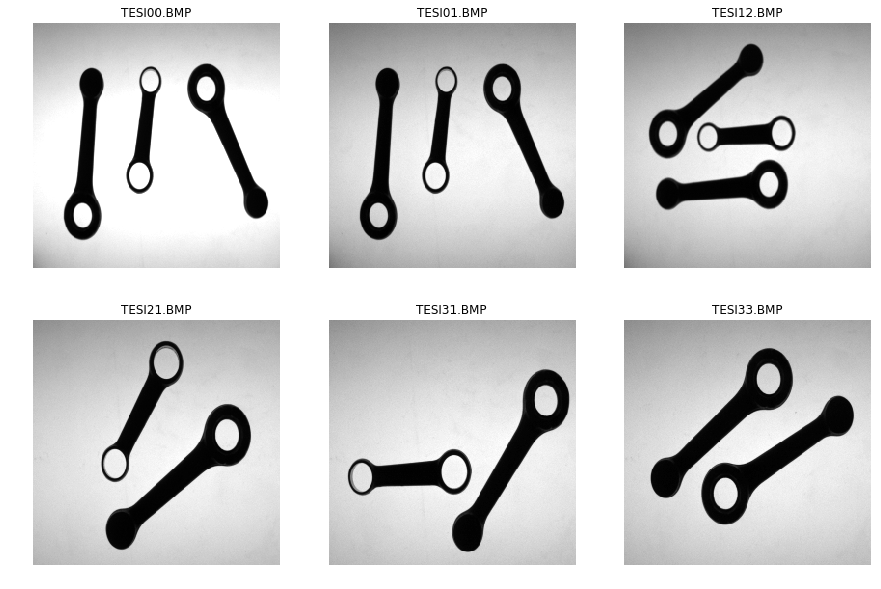

In [2]:
# Print the images in a grid
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, (img, path) in enumerate(zip(images_1, paths_1)):
    axs[i // 3, i % 3].imshow(img, cmap="gray")
    axs[i // 3, i % 3].set_title(path.name)
    axs[i // 3, i % 3].axis("off")
plt.show()

### Rod-type Detection

**Objectives**: detect the rods, detect the holes in each rod

The algorithm first preprocesses the image by applying a Gaussian filter (given $\sigma$, we set the kernel size to be equal to $\lceil (3 \sigma)^2 + 1 \rceil$.) and thresholding the image to create a binary image (we exploit the OpenCV method `cv2.threshold(img, thresh, maxval, type=cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)`). It then uses the `cv2.connectedComponentsWithStats()` function to find the connected components in the binary image. Each connected component corresponds to a rod in the image.

For each rod, the algorithm extracts the connected component and calculates its area, centroid, and number of holes. It then classifies the rod as either "Type A" (one hole) or "Type B" (two holes) based on the number of holes. Finally, it plots the connected component and displays the rod type.

COMPLETE DESCRIPTION.



In [ ]:
from src.rod_detection import detect_rods_blob

# Detects the rods for a single image, it outputs the various steps
# rod_info = detect_rods_blob(images_1[5], name=task1_names[5])

for i in range(6):
    rod_info = detect_rods_blob(images_1[i])

## Second task

While still meeting the requirement of the First Task, students should modify the system in order to 
deal with one (or more) of the following three changes in the characteristics of the working images:     
1. Images may contain other objects (i.e. screws and washers) that need not to be analysed by the 
system (such kind of objects are often referred to in computer vision as “distractors”). 
2. Rods can have contact points but do not overlap one to another.  
3. The inspection area may be dirty due to the presence of scattered iron powder.

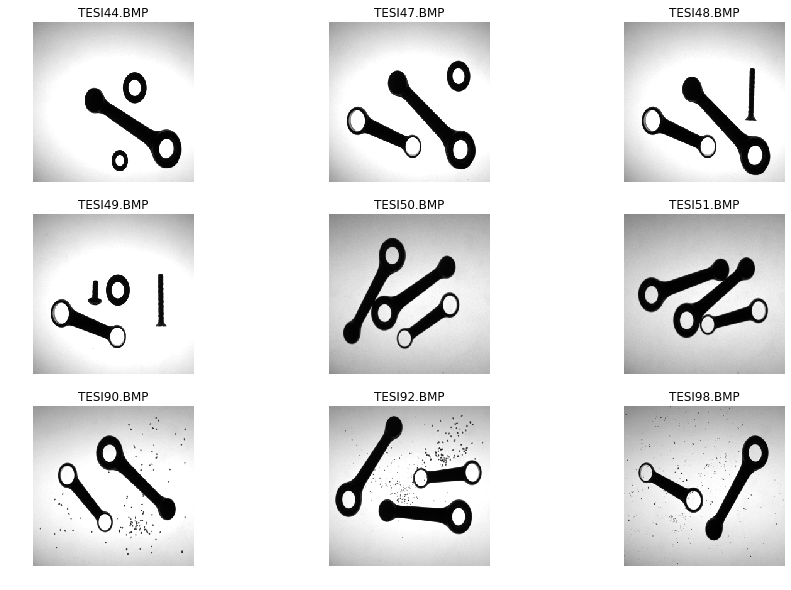

In [5]:
# Print the images in a grid
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
for i, (img, path) in enumerate(zip(images_2, paths_2)):
    axs[i // 3, i % 3].imshow(img, cmap="gray")
    axs[i // 3, i % 3].set_title(path.name)
    axs[i // 3, i % 3].axis("off")
plt.show()

INFO:root:Gaussian filter parameters --- sigma: 1, kernel size: 7
INFO:root:Filtering rods by area...
INFO:root:Number of rods found (CC): 1
Processing rods:   0%|          | 0/1 [00:00<?, ?it/s]INFO:root:
Processing rod 1...
INFO:root:Centroid (CC): (161, 105)
INFO:root:Area (CC): 4918
INFO:root:Number of holes: 1
INFO:root:Rod type: A

INFO:root:Rod Length: 181.6397
INFO:root:Rod Width: 56.0724
INFO:root:Rod Angle (deg): 141.9112
INFO:root:Rod Angle (rad): 2.4768

INFO:root:Rod mass center: (168, 173)
INFO:root:Width at mass center: 22.4722
INFO:root:Hole mass center: [(212, 202)]
INFO:root:Hole diameter: [33.37683868408203]
INFO:root:*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^

Processing rods: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]
INFO:root:Saving image: 


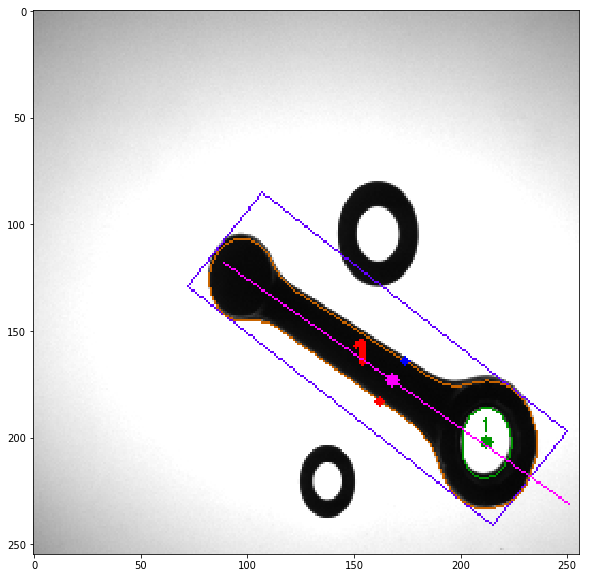

INFO:root:Gaussian filter parameters --- sigma: 1, kernel size: 7
INFO:root:Filtering rods by area...
INFO:root:Number of rods found (CC): 2
Processing rods:   0%|          | 0/2 [00:00<?, ?it/s]INFO:root:
Processing rod 1...
INFO:root:Centroid (CC): (205, 87)
INFO:root:Area (CC): 4972
INFO:root:Number of holes: 1
INFO:root:Rod type: A

INFO:root:Rod Length: 191.5672
INFO:root:Rod Width: 53.3304
INFO:root:Rod Angle (deg): 129.5597
INFO:root:Rod Angle (rad): 2.2612

INFO:root:Rod mass center: (170, 163)
INFO:root:Width at mass center: 21.2603
INFO:root:Hole mass center: [(208, 204)]
INFO:root:Hole diameter: [33.37683868408203]
INFO:root:*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^

Processing rods:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s]INFO:root:
Processing rod 2...
INFO:root:Centroid (CC): (166, 159)
INFO:root:Area (CC): 2273
INFO:root:Number of holes: 2
INFO:root:Rod type: B

INFO:root:Rod Length: 129.2447
INFO:root:Rod Wi

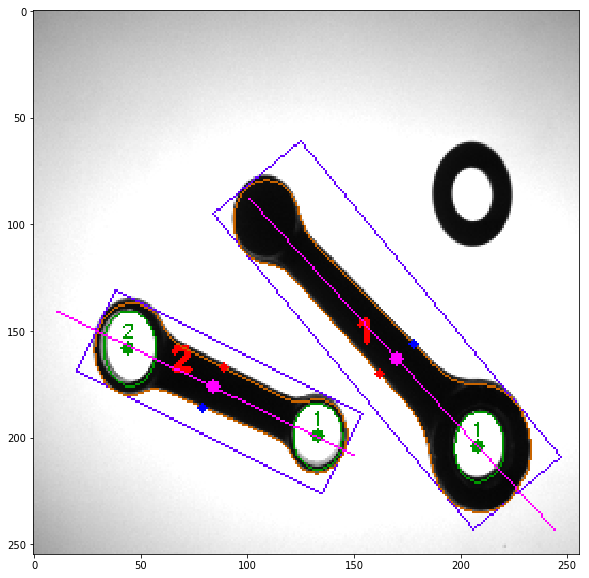

INFO:root:Gaussian filter parameters --- sigma: 1, kernel size: 7
INFO:root:Filtering rods by area...
INFO:root:Number of rods found (CC): 2
Processing rods:   0%|          | 0/2 [00:00<?, ?it/s]INFO:root:
Processing rod 1...
INFO:root:Centroid (CC): (202, 117)
INFO:root:Area (CC): 4976
INFO:root:Number of holes: 1
INFO:root:Rod type: A

INFO:root:Rod Length: 191.2924
INFO:root:Rod Width: 53.6275
INFO:root:Rod Angle (deg): 129.7048
INFO:root:Rod Angle (rad): 2.2638

INFO:root:Rod mass center: (169, 173)
INFO:root:Width at mass center: 21.2132
INFO:root:Hole mass center: [(208, 213)]
INFO:root:Hole diameter: [33.241737365722656]
INFO:root:*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^

Processing rods:  50%|█████     | 1/2 [00:00<00:00,  1.92it/s]INFO:root:
Processing rod 2...
INFO:root:Centroid (CC): (165, 168)
INFO:root:Area (CC): 2265
INFO:root:Number of holes: 2
INFO:root:Rod type: B

INFO:root:Rod Length: 129.3285
INFO:root:Rod 

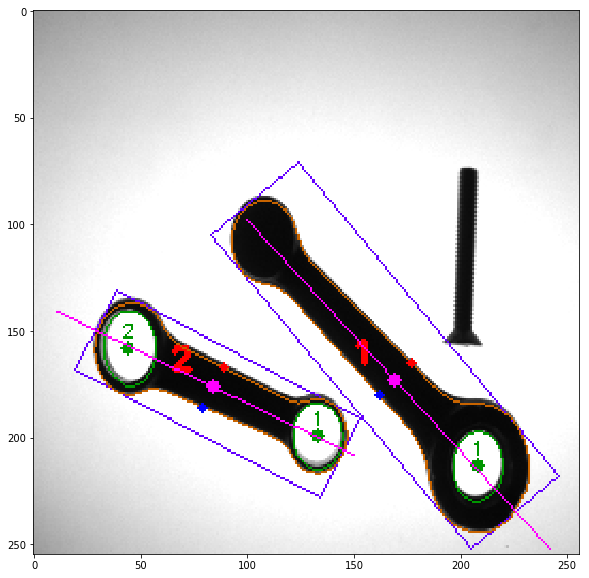

INFO:root:Gaussian filter parameters --- sigma: 1, kernel size: 7
INFO:root:Filtering rods by area...
INFO:root:Number of rods found (CC): 1
Processing rods:   0%|          | 0/1 [00:00<?, ?it/s]INFO:root:
Processing rod 1...
INFO:root:Centroid (CC): (203, 140)
INFO:root:Area (CC): 2311
INFO:root:Number of holes: 2
INFO:root:Rod type: B

INFO:root:Rod Length: 128.7523
INFO:root:Rod Width: 42.2035
INFO:root:Rod Angle (deg): 154.7672
INFO:root:Rod Angle (rad): 2.7012

INFO:root:Rod mass center: (84, 175)
INFO:root:Width at mass center: 21.0238
INFO:root:Hole mass center: [(133, 196), (44, 158)]
INFO:root:Hole diameter: [31.257200241088867, 35.525238037109375]
INFO:root:*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^

Processing rods: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]
INFO:root:Saving image: 


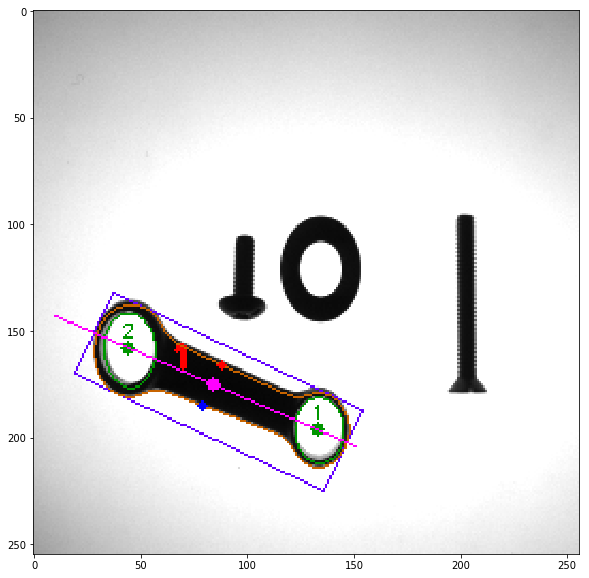

INFO:root:Gaussian filter parameters --- sigma: 1, kernel size: 7
INFO:root:Filtering rods by area...
INFO:root:Number of rods found (CC): 3
Processing rods:   0%|          | 0/3 [00:00<?, ?it/s]INFO:root:
Processing rod 1...
INFO:root:Centroid (CC): (72, 119)
INFO:root:Area (CC): 3860
INFO:root:Number of holes: 1
INFO:root:Rod type: A

INFO:root:Rod Length: 181.7465
INFO:root:Rod Width: 44.1795
INFO:root:Rod Angle (deg): 65.8286
INFO:root:Rod Angle (rad): 1.1489

INFO:root:Rod mass center: (75, 113)
INFO:root:Width at mass center: 17.4642
INFO:root:Hole mass center: [(100, 67)]
INFO:root:Hole diameter: [29.497983932495117]
INFO:root:*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^

Processing rods:  33%|███▎      | 1/3 [00:00<00:00,  4.31it/s]INFO:root:
Processing rod 2...
INFO:root:Centroid (CC): (130, 127)
INFO:root:Area (CC): 3737
INFO:root:Number of holes: 1
INFO:root:Rod type: A

INFO:root:Rod Length: 162.5913
INFO:root:Rod Widt

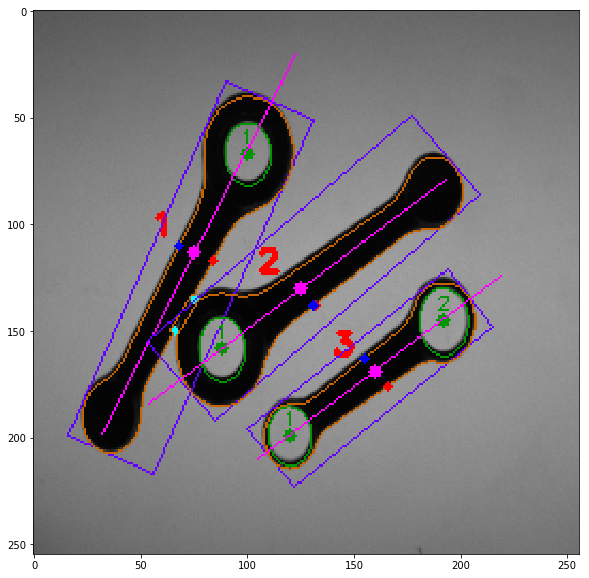

INFO:root:Gaussian filter parameters --- sigma: 1, kernel size: 7
INFO:root:Filtering rods by area...
INFO:root:Number of rods found (CC): 3
Processing rods:   0%|          | 0/3 [00:00<?, ?it/s]INFO:root:
Processing rod 1...
INFO:root:Centroid (CC): (140, 134)
INFO:root:Area (CC): 3715
INFO:root:Number of holes: 1
INFO:root:Rod type: A

INFO:root:Rod Length: 164.7559
INFO:root:Rod Width: 47.3761
INFO:root:Rod Angle (deg): 45.0000
INFO:root:Rod Angle (rad): 0.7854

INFO:root:Rod mass center: (135, 138)
INFO:root:Width at mass center: 1.0000
INFO:root:Hole mass center: [(99, 170)]
INFO:root:Hole diameter: [31.06464958190918]
INFO:root:*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^

Processing rods:  33%|███▎      | 1/3 [00:00<00:00,  4.05it/s]INFO:root:
Processing rod 2...
INFO:root:Centroid (CC): (90, 112)
INFO:root:Area (CC): 3723
INFO:root:Number of holes: 1
INFO:root:Rod type: A

INFO:root:Rod Length: 153.1815
INFO:root:Rod Width

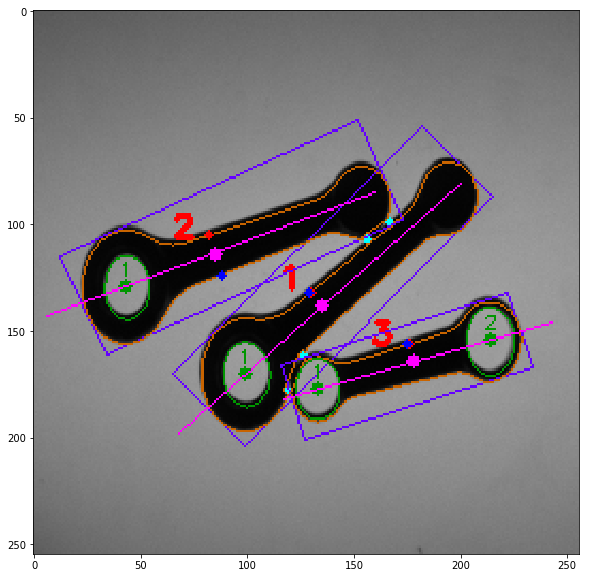

INFO:root:Gaussian filter parameters --- sigma: 1, kernel size: 7
INFO:root:Filtering rods by area...
INFO:root:Number of rods found (CC): 2
Processing rods:   0%|          | 0/2 [00:00<?, ?it/s]INFO:root:
Processing rod 1...
INFO:root:Centroid (CC): (152, 31)
INFO:root:Area (CC): 3859
INFO:root:Number of holes: 1
INFO:root:Rod type: A

INFO:root:Rod Length: 167.2491
INFO:root:Rod Width: 47.8489
INFO:root:Rod Angle (deg): 131.7845
INFO:root:Rod Angle (rad): 2.3001

INFO:root:Rod mass center: (156, 109)
INFO:root:Width at mass center: 19.1050
INFO:root:Hole mass center: [(121, 76)]
INFO:root:Hole diameter: [29.497983932495117]
INFO:root:*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^

Processing rods:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s]INFO:root:
Processing rod 2...
INFO:root:Centroid (CC): (160, 113)
INFO:root:Area (CC): 1787
INFO:root:Number of holes: 2
INFO:root:Rod type: B

INFO:root:Rod Length: 127.2211
INFO:root:Rod Wi

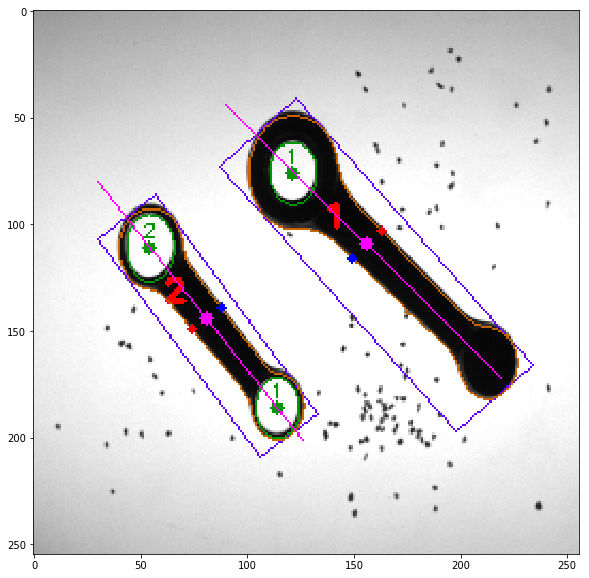

INFO:root:Gaussian filter parameters --- sigma: 1, kernel size: 7
INFO:root:Filtering rods by area...
INFO:root:Number of rods found (CC): 3
Processing rods:   0%|          | 0/3 [00:00<?, ?it/s]INFO:root:
Processing rod 1...
INFO:root:Centroid (CC): (62, 99)
INFO:root:Area (CC): 3856
INFO:root:Number of holes: 1
INFO:root:Rod type: A

INFO:root:Rod Length: 178.2238
INFO:root:Rod Width: 44.6488
INFO:root:Rod Angle (deg): 61.1519
INFO:root:Rod Angle (rad): 1.0673

INFO:root:Rod mass center: (58, 105)
INFO:root:Width at mass center: 1.0000
INFO:root:Hole mass center: [(31, 149)]
INFO:root:Hole diameter: [30.26569175720215]
INFO:root:*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^

Processing rods:  33%|███▎      | 1/3 [00:00<00:00,  5.32it/s]INFO:root:
Processing rod 2...
INFO:root:Centroid (CC): (224, 27)
INFO:root:Area (CC): 1681
INFO:root:Number of holes: 2
INFO:root:Rod type: B

INFO:root:Rod Length: 110.0353
INFO:root:Rod Width: 3

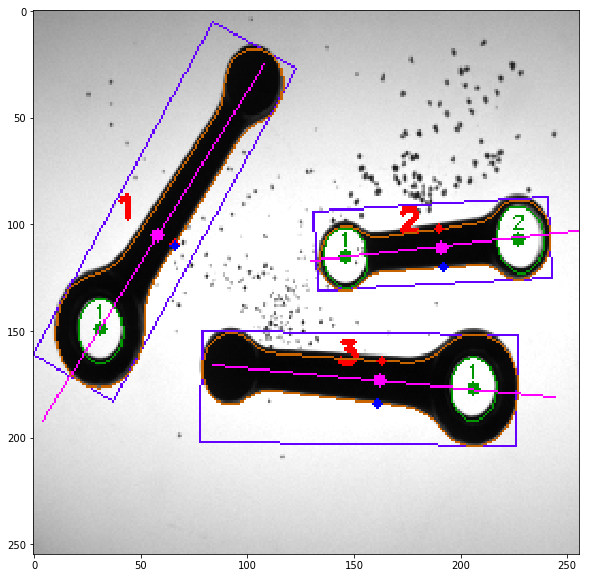

INFO:root:Gaussian filter parameters --- sigma: 1, kernel size: 7
INFO:root:Filtering rods by area...
INFO:root:Number of rods found (CC): 2
Processing rods:   0%|          | 0/2 [00:00<?, ?it/s]INFO:root:
Processing rod 1...
INFO:root:Centroid (CC): (180, 127)
INFO:root:Area (CC): 3849
INFO:root:Number of holes: 1
INFO:root:Rod type: A

INFO:root:Rod Length: 180.7495
INFO:root:Rod Width: 43.7549
INFO:root:Rod Angle (deg): 64.7327
INFO:root:Rod Angle (rad): 1.1298

INFO:root:Rod mass center: (183, 122)
INFO:root:Width at mass center: 1.0000
INFO:root:Hole mass center: [(208, 75)]
INFO:root:Hole diameter: [29.6143856048584]
INFO:root:*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^

Processing rods:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s]INFO:root:
Processing rod 2...
INFO:root:Centroid (CC): (76, 130)
INFO:root:Area (CC): 1745
INFO:root:Number of holes: 2
INFO:root:Rod type: B

INFO:root:Rod Length: 116.1985
INFO:root:Rod Width:

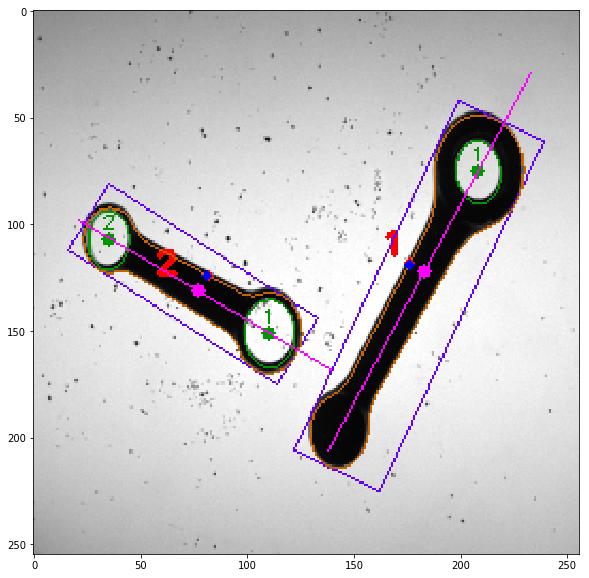

In [131]:
for i in range(9):
    rod_info = detect_rods_blob(images_2[i], min_area=1500, detect_contact_pts=True)